# Modelling

In [3]:
import os
import math
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import re
import seaborn as sns; sns.set(color_codes=True)
sns.set_style("white")
from scipy.ndimage.filters import gaussian_filter
import shap
import pickle
from math import cos, sin, asin, sqrt

from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error, mean_squared_error
from sklearn.utils import shuffle
import xgboost as xgb
from xgboost import plot_importance

import tensorflow as tf    
from tensorflow import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, LSTM, Input, concatenate, SimpleRNN, Dropout, Bidirectional, Embedding, GRU
from keras.callbacks import History
from keras import regularizers
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
history = History()

In [4]:
df = pd.read_csv("C:\\Data\\Processed_M3\\Sites_10min_time_final.csv")

In [5]:
timeInterval = '10min_time'
# df.columns = ['date', 'site', timeInterval, 'occupancy0', 'speed0', 'volume0','dateTime', 'hour', 'dayOfWeek', 'dayType']
df.columns = ['date','site','timeInterval','occupancy0','speed0','volume0','dateTime','hour','dayOfWeek','dayType','density0','state0']
sites = set(df['site'])
dateTime = pd.to_datetime(df['dateTime'])
df['interval'] = [v.hour*6+int(v.minute/10) for v in dateTime]
df

,date,site,timeInterval,occupancy0,speed0,volume0,dateTime,hour,dayOfWeek,dayType,density0,state0,interval
0,2016-07-01,14005 WB P0,00:00:00,0.000000,100.000000,67.728571,2016-07-01 00:00:00,0,4,0,0.000000,0.0,0
1,2016-07-01,14005 WB P0,00:10:00,0.000000,100.000000,62.821429,2016-07-01 00:10:00,0,4,0,0.000000,0.0,1
2,2016-07-01,14005 WB P0,00:20:00,0.000000,100.000000,53.171429,2016-07-01 00:20:00,0,4,0,0.000000,0.0,2
3,2016-07-01,14005 WB P0,00:30:00,0.000000,100.000000,51.971429,2016-07-01 00:30:00,0,4,0,0.000000,0.0,3
4,2016-07-01,14005 WB P0,00:40:00,0.000000,100.000000,44.350000,2016-07-01 00:40:00,0,4,0,0.000000,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
51403,2016-08-21,14063 WB P0,23:10:00,0.890000,97.012222,62.000000,2016-08-21 23:10:00,23,6,1,1.260833,0.0,139
51404,2016-08-21,14063 WB P0,23:20:00,0.436667,96.243056,78.750000,2016-08-21 23:20:00,23,6,1,0.618611,0.0,140
51405,2016-08-21,14063 WB P0,23:30:00,0.490000,96.452778,36.000000,2016-08-21 23:30:00,23,6,1,0.694167,0.0,141
51406,2016-08-21,14063 WB P0,23:40:00,0.520000,96.370833,70.687500,2016-08-21 23:40:00,23,6,1,0.736667,0.0,142


## Features

In [6]:
# The lag is the time distance between time-factors and time-target
# If the lag is 0, we say we try to use the data 10 mins ago to forecast the now traffic condition
# If the lag is 2, we say we try to use the data 30 mins ago to forecast the now traffic condition
# If the lag is 5, we say we try to use the data 60 mins ago to forecast the now traffic condition

window = 6*10
lag = 11 # lag 0 means the label is 10 mins later
lag = lag + window

# sites = ['14005 WB P0', '14017 WB P0', '14025 WB P0', '14035 WB P0', '14045 WB P0', '14055 WB P0', '14061 WB P0']
# # sites = ['14025 WB P0']
# sites = ['14025 WB P0', '14035 WB P0', '14045 WB P0', '14055 WB P0']

# lag_names = ['volume'+str(t) for t in range(lag+1)]
volume_names = 'volume'+str(lag)
hour_names = 'hour'+str(lag)
dayOfWeek_names = 'dayOfWeek'+str(lag)
interval_names = 'interval'+str(lag)
dayType_names = 'dayType'+str(lag)
data_features = [volume_names, hour_names, dayOfWeek_names, interval_names, dayType_names]

column_names = list(df.columns.values) + data_features
print(column_names)

data = pd.DataFrame()
for site in sites:
    df1 = df[df['site']==site]
    df1.sort_values('dateTime')
    # df1 = pd.concat([df1]+ [df1['volume0'].shift(t) for t in range(lag+1)], axis=1)
    df1 = pd.concat([df1]+ [df1['volume0'].shift(lag)], axis=1)
    df1 = pd.concat([df1]+ [df1['hour'].shift(lag)], axis=1)
    df1 = pd.concat([df1]+ [df1['dayOfWeek'].shift(lag)], axis=1)
    df1 = pd.concat([df1]+ [df1['interval'].shift(lag)], axis=1)
    df1 = pd.concat([df1]+ [df1['dayType'].shift(lag)], axis=1)
    data = data.append(df1)
data.columns = column_names
#data = data.dropna()

features = ['volume' + str(lag)]
features_name = 'volume' + str(lag)
aux_features = []#[interval_names, dayType_names]
columns = features + aux_features
data

['date', 'site', 'timeInterval', 'occupancy0', 'speed0', 'volume0', 'dateTime', 'hour', 'dayOfWeek', 'dayType', 'density0', 'state0', 'interval', 'volume71', 'hour71', 'dayOfWeek71', 'interval71', 'dayType71']


,date,site,timeInterval,occupancy0,speed0,volume0,dateTime,hour,dayOfWeek,dayType,density0,state0,interval,volume71,hour71,dayOfWeek71,interval71,dayType71
144,2016-07-01,14011 WB P0,00:00:00,0.98125,87.051210,120.000000,2016-07-01 00:00:00,0,4,0,1.390104,0.0,0,NaN,NaN,NaN,NaN,NaN
145,2016-07-01,14011 WB P0,00:10:00,0.95125,91.391111,136.000000,2016-07-01 00:10:00,0,4,0,1.347604,0.0,1,NaN,NaN,NaN,NaN,NaN
146,2016-07-01,14011 WB P0,00:20:00,0.85125,86.354167,106.000000,2016-07-01 00:20:00,0,4,0,1.205938,0.0,2,NaN,NaN,NaN,NaN,NaN
147,2016-07-01,14011 WB P0,00:30:00,1.00375,87.122685,80.457143,2016-07-01 00:30:00,0,4,0,1.421979,0.0,3,NaN,NaN,NaN,NaN,NaN
148,2016-07-01,14011 WB P0,00:40:00,0.57125,92.194444,84.000000,2016-07-01 00:40:00,0,4,0,0.809271,0.0,4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51259,2016-08-21,14055 WB P0,23:10:00,1.41625,96.194454,236.000000,2016-08-21 23:10:00,23,6,1,2.006354,0.0,139,1668.0,11.0,6.0,68.0,1.0
51260,2016-08-21,14055 WB P0,23:20:00,1.07875,94.499350,184.000000,2016-08-21 23:20:00,23,6,1,1.528229,0.0,140,1850.0,11.0,6.0,69.0,1.0
51261,2016-08-21,14055 WB P0,23:30:00,0.85875,95.982659,325.125000,2016-08-21 23:30:00,23,6,1,1.216562,0.0,141,1762.0,11.0,6.0,70.0,1.0
51262,2016-08-21,14055 WB P0,23:40:00,0.97500,92.205635,154.000000,2016-08-21 23:40:00,23,6,1,1.381250,0.0,142,1838.0,11.0,6.0,71.0,1.0


## Evaluation

In [7]:
def evaluate_model(y_pred_train, y_pred_test, y_train_true, y_test_true, y_base_train, y_base_test):
    """
    Function for calculating accuracy metrics. Inputs are list of predictions.
    """
    results = {}
    
    results['MAE train'] = mean_absolute_error(y_pred_train, y_train_true) 
    results['MAE test'] = mean_absolute_error(y_pred_test, y_test_true)
    results['MAE train base'] = mean_absolute_error(y_base_train, y_train_true)
    results['MAE test base'] = mean_absolute_error(y_base_test, y_test_true)
    
    results['MRE test'] = mean_absolute_percentage_error(y_pred_test, y_test_true)
    results['RMSE test'] = math.sqrt(mean_squared_error(y_pred_test, y_test_true))
    
    #print('results', results)
    #print('y_base_train', y_base_train) # y_base_train, y_base_test are not dataframe anymore
    
    total_error_train, total_error_test = 0,0
    total_error_train_base, total_error_test_base = 0,0
    
    for i in range(0, len(y_train_true)):
        total_error_train_base += np.abs(y_base_train[i] - y_train_true[i])
        total_error_train += np.abs(y_pred_train[i] - y_train_true[i])
    
    for i in range(0, len(y_test_true)):
        total_error_test_base += np.abs(y_base_test[i] - y_test_true[i])
        total_error_test += np.abs(y_pred_test[i] - y_test_true[i])
        
    results['Baseline model total error (on train set)'] = total_error_train_base
    results['Baseline model total error (on test set)'] = total_error_test_base
    results['Our model total error (on train set)'] = total_error_train
    results['Our model total error (on test set)'] = total_error_test 
    
    return results

In [8]:
def evaluate_model_ann(y_pred_train, y_pred_test, y_train_true, y_test_true, y_base_train, y_base_test):
    """
    Calculate mean squared error and total absolute error.
    evaluate_model(y_pred_train, y_pred_test, y_train_win, y_test_win, y_train_win_base, y_test_win_base)
    """
    results = {}
    
    results['train mae'] = mean_absolute_error(y_pred_train, y_train_true) 
    results['test mae'] = mean_absolute_error(y_pred_test, y_test_true)
    results['base train mae'] = mean_absolute_error(y_base_train, y_train_true)
    results['base test mae'] = mean_absolute_error(y_base_test, y_test_true)
    
    results['test mre'] = mean_absolute_percentage_error(y_pred_test, y_test_true)
    results['test rmse'] = mean_squared_error(y_pred_test, y_test_true)**.5
    
    error_train, error_test = [],[]
    error_train_base, error_test_base = [],[]
    
    for i in range(0, len(y_train_true)):
        error_train_base.append(np.abs(y_base_train[i] - y_train_true[i]))
        error_train.append(np.abs(y_pred_train[i] - y_train_true[i]))
    
    for i in range(0, len(y_test_true)):
        error_test_base.append(np.abs(y_base_test[i] - y_test_true[i]))
        error_test.append(np.abs(y_pred_test[i] - y_test_true[i]))
        
    results['base model train error'] = sum(error_train_base)
    results['base model test error'] = sum(error_test_base)
    results['our model train error'] = sum(error_train)
    results['our model test error'] = sum(error_test) 
    
    return results

In [9]:
def scatter_plot(y_test,y_pred_test,filePath):
    y_true = np.array(y_test)
    y_predicted = y_pred_test
    t = y_true
    fig, ax = plt.subplots()
    ax.scatter(y_true, y_predicted, c=t, s=2, cmap='viridis')
    ax.plot([0,2000], [0,2000], 'k--', lw=4)
    ax.set_xlabel('True', fontsize=20)
    ax.set_ylabel('Predicted', fontsize=20)
    ax.xaxis.set_ticks(np.arange(0,2001,500))
    ax.yaxis.set_ticks(np.arange(0,2001,500))
    ax.tick_params(axis='both', labelsize=15, direction='inout',bottom=True, left=True)
    #regression line
    y_true, y_predicted = y_true.reshape(-1,1), y_predicted.reshape(-1,1)
    ax.annotate("R2 = {:.3f}".format(r2_score(y_true, y_predicted)), (0, 1400), fontsize=20)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.savefig(filePath, bbox_inches='tight')
    plt.show()
    
def time_series_plot(y_test,y_pred_test,filePath):
    y_true = np.array(y_test)*6
    y_predicted = y_pred_test*6
    t = y_true
    fig, ax = plt.subplots(figsize=(10, 1.5))
    plt.plot(y_predicted, 'r', lw=.5)
    plt.plot(y_true, 'b', lw=.5)
    ax.set_ylabel('Flow', fontsize=12)

    ax.tick_params(axis='both', labelsize=12, direction='inout',bottom=True, left=True)
    ax.set_xticklabels([])
    plt.savefig(filePath, bbox_inches='tight')
    plt.show()
    
def show_time_scatter_plot(y_test,y_pred_test,title = "BiLSTM\\"):
    
    filePath = os.getcwd() + '\\Figs\\Scatter\\' + title
    imagePath = filePath + str(lag)+'_'+str(siteId)+'.png'
    if not os.path.exists(filePath):                                     
        os.makedirs(filePath)
    scatter_plot(y_test,y_pred_test,imagePath)
    
    filePath = os.getcwd() + '\\Figs\\TimeSeries\\' + title
    imagePath = filePath + str(lag)+'_'+str(siteId)+'.png'
    if not os.path.exists(filePath):
        os.makedirs(filePath)
    time_series_plot(y_test,y_pred_test,imagePath)

In [10]:
def feature_importance(x_train):
    crayon = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']

    plt.figure(figsize = (6, 8))
    dt_importance_df = pd.DataFrame({"attributes": x_train.columns, "importance": dt.feature_importances_})
    dt_importance_df = dt_importance_df.sort_values("importance", ascending = True)
    dt_importance_df = dt_importance_df[dt_importance_df["importance"] > 0.001]
    plt.barh(dt_importance_df["attributes"], dt_importance_df["importance"], orientation = "horizontal", color = crayon)
    plt.xlabel("Feature Importance")

## Helper Functions for Normalising Data

In [11]:
def denormalise(predictions, scaler): #IMPORTANT: run this
    """
    Denormalise the predictions back to the previous scale. 
    """
    predictions = predictions.reshape(1,-1)
    pred = scaler.inverse_transform(predictions)
    
    return pred

In [12]:
def normalise(columns, df): #IMPORTANT: run this
    """
    Normalise variables given the list 'columns'. Used for SVR model. 
    
    Parameters:
    columns (list): list of strings containing feature names that need to be normalised.
    df (pandas dataframe): training data.
    
    """
    min_max_scaler = preprocessing.MinMaxScaler() #normalise to make variables comparable 
    final_df = pd.DataFrame(min_max_scaler.fit_transform(df[columns]), columns = columns)
    
    for col in df.columns: #add back the columns that weren't normalised
        if col not in columns: 
            final_df[col] = df[col].values
    
#     if 'volume' in columns: #also store the unnormalised travel times if necessary 
#         final_df['volume_unnorm'] = df['volume'].values
    return final_df, min_max_scaler

In [13]:
def create_auxiliary_input(train_x, test_x, features): 
    """
    Function to filter out only the auxiliary features. 
    Auxiliary features are all the other features other than the lagged features.
    
    """
    
    train_x_aux = train_x[features]
    test_x_aux = test_x[features]
    
    return train_x_aux, test_x_aux

## Helper Functions for Window the data

when we try to use 1 previous hour to preduct 1 further hour, the input window is 2.

Input window = history length (1) + lag (1)

In [14]:
def time_series_window_generator(x,y,lag,window,features_name):
    """
    1. we assume the train test is dataframe format, 
    and it contains both time series and other features
       
    2. we consider the base line is the first data points of input (only work for methods don't need normalization)
    
    3. for methods use normalization, we need to generate the baseline inside the method itself
    """
    # to create the correct window match
    # --------------------------------------
    #  1  2  3  4  5   6  ......
    # --------------  --
    #   features      label
    # 
    # this is a window 6, lag 1, data length 5 data match for time series.
    # didn't use this function for now because vol-x are manually generated

    local_x = x.copy()
    local_x_base = x[features_name].copy()
    local_y = y.copy()
    #print(y)
    
    index_x = local_x.index
    index_y = local_y.index
    data_n = len(x) - lag               # for 5 window 0 lag, means 5 data points predict 1 future hour.

    y_base_windowed = []
    y_windowed = []
    x_windowed = []
    
    for i in range(data_n):
        x_windowed.append(local_x[i : i+window].values.tolist())  # get features
        y_windowed.append(local_y[index_y[i]])
        y_base_windowed.append(local_x_base[index_x[i]])
#         if i == 0:
#             print('start_index ',index_x[0])
#             print("* processing the time series " + str(window) +" window in lag " + str(lag-window))
#             print('features: ', local_x[i : i+window], ' in ', str(index_x[0]),  ' to ', str(index_x[0]+window))
#             print('label: ', local_y[index_y[i]], ' in ', str(index_y[0]))

    # reshape to (n_sample, n_feautre * n_length) still 2d
    x_windowed = np.array(x_windowed)
    # print('input shape before:', x_windowed.shape)
    x_windowed = np.reshape(x_windowed, (x_windowed.shape[0],-1))
    # print('input shape after:', x_windowed.shape)
    
    return x_windowed, y_windowed, y_base_windowed

In [15]:
def prepare_nn_data(x,y,lag,window,time_feautre_name = 'volume1'):
    """
    Reformat data to appropriate form for the recurrent neural
    network.
    1. get time series data in array (n_sample,1,n_length)
    2. get aux data in array (n_sample,1,n_features)
    3. get y & y_base in array (n_sample,)
    
    to separate 1 and 2, use time_feautre_name
    """
    # separate 1 and 2
    print("==================")
    print("process ann data")
    local_x = x.copy()
    index_y = y.index
    time_feature_df = local_x[time_feautre_name]
    aux_feature_df = local_x.drop(time_feautre_name, axis=1)

    x_windowed = []
    x_windowed_aux = []
    y_base_windowed = []
    y_windowed = []
    
    data_n = len(x) - lag
    for i in range(data_n):
        x_windowed.append(time_feature_df[i : i+window].values.tolist())     # get time series features
        x_windowed_aux.append(aux_feature_df[i : i+window].values.tolist())  # get other time related features
        y_base_windowed.append(time_feature_df[i])                    # get first of input time slot data as baseline 
        y_windowed.append((y[index_y[i]]))                                   # get grand truth
        
    # reshape to (n_sample, 1 feautre)
    x_windowed = np.asarray(x_windowed).astype(np.float32)
    x_windowed_aux = np.asarray(x_windowed_aux).astype(np.float32)
    y_base_windowed = np.asarray(y_base_windowed).astype(np.float32)
    y_windowed = np.asarray(y_windowed).astype(np.float32)
    #print('before reshape for tensorflow usage')
    #print('input shape of time series:', x_windowed.shape)
    #print('input shape of aux features:', x_windowed_aux.shape)
    #print('sample input time series:',x_windowed[0])
    #print('sample input aux features::',x_windowed_aux[0])
    #print('target shape:',y_windowed.shape)
    #print('sample target:',y_windowed[0])
    
    x_windowed = np.reshape(x_windowed, (x_windowed.shape[0], 1, x_windowed.shape[1]))
    x_windowed_aux = np.reshape(x_windowed_aux, (x_windowed_aux.shape[0],1, -1))      # for merge must be n,1,m.
    y_base_windowed = np.reshape(y_base_windowed, (y_base_windowed.shape[0], 1))
    y_windowed = np.reshape(y_windowed, (y_windowed.shape[0], 1))
    #print('after reshape for tensorflow usage')
    #print('input shape of time series:', x_windowed.shape)
    #print('input shape of aux features:', x_windowed_aux.shape)
    #print('target shape:',y_windowed.shape)
    
    return x_windowed, x_windowed_aux, y_windowed, y_base_windowed

# Models

# Neural network models

The following sections use different neural networks, which are MLP, RNN, LSTM, GRU and BILSTM. However their general structure are same.

See below


In [16]:
# ################
# this model architecture actually is a 2 branch model
#  input1 time series               
#     |
#  RNN model        
#     |                       
#  RNN output     input2 other features
#     |                     |
#     -----------------------
#                |
#              Concat
#                |
#               MLP
#                |
#           final output


# RNN

14011 WB P0
process ann data
process ann data
train mae 69.47933
test mae 70.12938
base train mae 842.9468
base test mae 848.27545
test mre 0.2472095
test rmse 96.9993607018237
base model train error [4785409.]
base model test error [1234240.8]
our model train error [394434.75]
our model test error [102038.3]
Model R square (train):  0.9635906836362298
Model R square (test):  0.9640784397812348
Base R square (train):  -1.9216588992524675
Base R square (test):  -1.9863643404381723


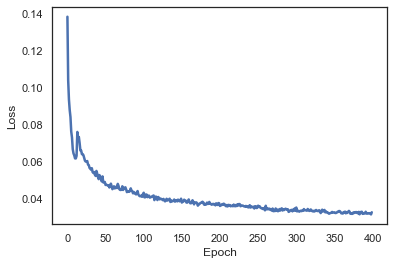

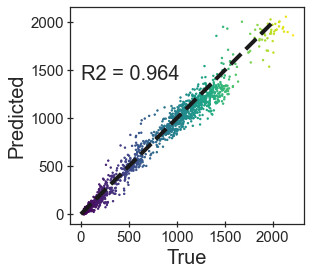

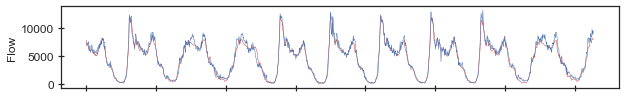

14037 WB P0
process ann data
process ann data
train mae 79.5026
test mae 80.43444
base train mae 1042.2783
base test mae 1041.118
test mre 0.15838085
test rmse 126.70154399217083
base model train error [5917014.5]
base model test error [1514827.4]
our model train error [451335.6]
our model test error [117032.13]
Model R square (train):  0.9609936923109781
Model R square (test):  0.9566604897171035
Base R square (train):  -2.1450963329377184
Base R square (test):  -2.1993793631833833


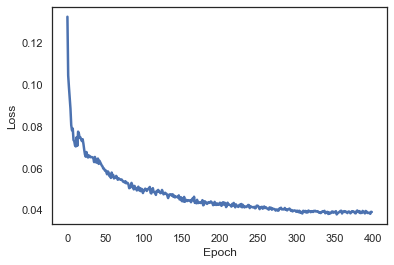

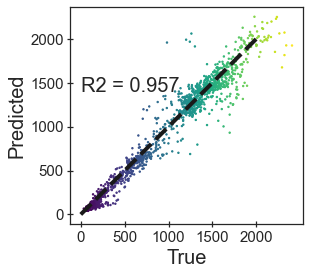

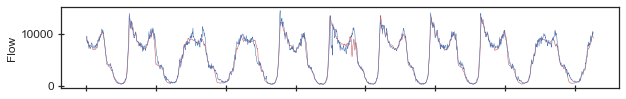

14025 WB P0
process ann data
process ann data
train mae 67.8617
test mae 69.024734
base train mae 1015.20233
base test mae 1019.23193
test mre 0.13375053
test rmse 101.49818155698652
base model train error [5763301.]
base model test error [1482982.5]
our model train error [385251.72]
our model test error [100431.]
Model R square (train):  0.9720153561784783
Model R square (test):  0.9718968678222211
Base R square (train):  -2.008638020588473
Base R square (test):  -2.0811300704187845


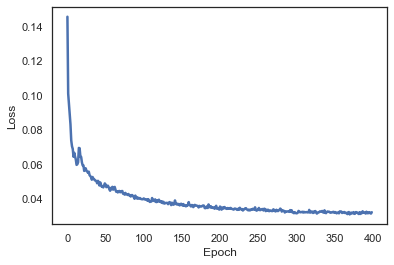

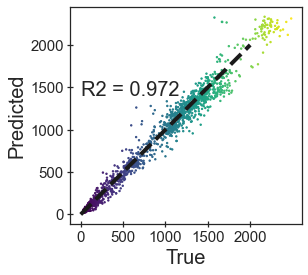

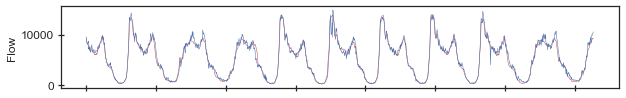

14049 WB P0
process ann data
process ann data
train mae 42.285114
test mae 41.100163
base train mae 632.0373
base test mae 640.5112
test mre 0.11767271
test rmse 63.05052266399641
base model train error [3588077.2]
base model test error [931944.]
our model train error [240052.88]
our model test error [59800.766]
Model R square (train):  0.9696581198215705
Model R square (test):  0.9710065457091709
Base R square (train):  -2.186522337882114
Base R square (test):  -2.2615910518109774


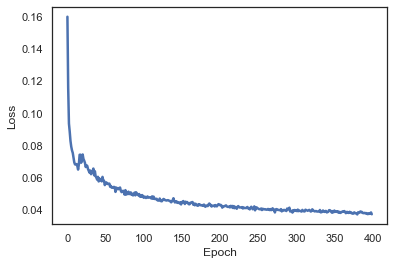

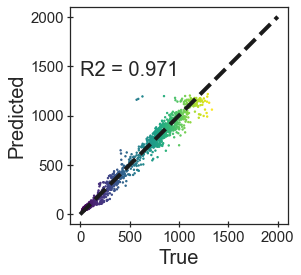

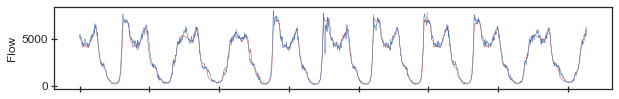

14063 WB P0
process ann data
process ann data
train mae 27.256678
test mae 27.526178
base train mae 365.34653
base test mae 361.66077
test mre 2.083614
test rmse 39.314262120185944
base model train error [2074073.9]
base model test error [526216.5]
our model train error [154735.98]
our model test error [40050.613]
Model R square (train):  0.9671278692605256
Model R square (test):  0.9655636900055701
Base R square (train):  -2.083166435519254
Base R square (test):  -2.171444004025782


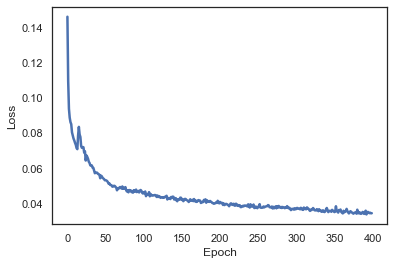

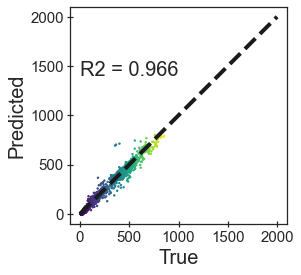

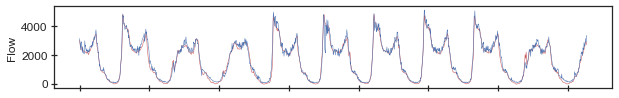

14005 WB P0
process ann data
process ann data
train mae 47.26666
test mae 48.21658
base train mae 463.4476
base test mae 487.46176
test mre 0.24671073
test rmse 66.1037337317738
base model train error [2630990.8]
base model test error [709256.7]
our model train error [268332.78]
our model test error [70155.11]
Model R square (train):  0.9439667677108399
Model R square (test):  0.9486947918473824
Base R square (train):  -1.9835709413165334
Base R square (test):  -2.0947650402226916


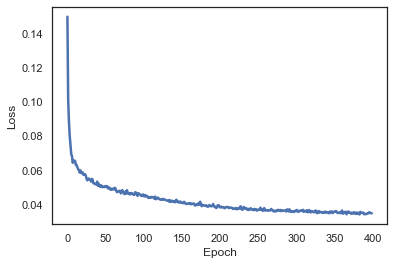

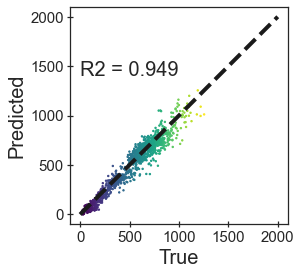

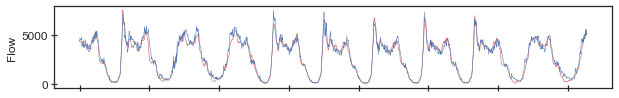

14055 WB P0
process ann data
process ann data
train mae 87.65711
test mae 94.643814
base train mae 1197.4545
base test mae 1191.282
test mre 0.24324778
test rmse 139.63884779136498
base model train error [6797950.]
base model test error [1733315.1]
our model train error [497629.1]
our model test error [137706.86]
Model R square (train):  0.9671728701823574
Model R square (test):  0.9591883180999566
Base R square (train):  -2.169543973675732
Base R square (test):  -2.2409352691819606


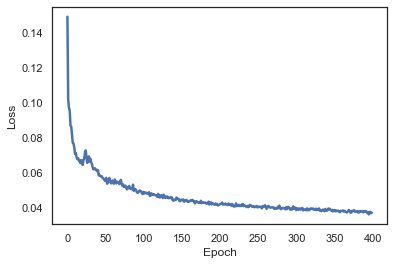

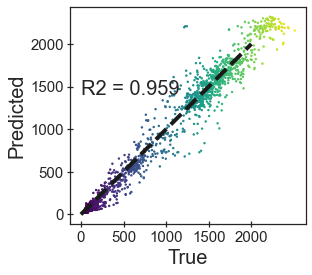

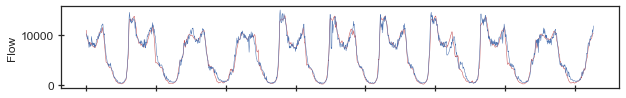

sums of MAE test /counter 61.582184110369


In [17]:
final = pd.DataFrame()
MAE_RNN, MRE_RNN, RMSE_RNN = {},{},{}


for siteId in sites:
    print(siteId)
    tmp = data[data['site']==siteId]
    tmp = tmp.reset_index()
    tmp = tmp.dropna()
    if len(tmp) == 0:
        print('error',siteId)
        continue

    # ################
    # Section 1 : Data
    # ################
    index = len(tmp) * 0.80
    train = tmp.loc[:index]
    test = tmp.loc[index-1:]
    len(train)/len(tmp) * 100 

    ### Normalise all data (simulated and real accidents dataset) and create lags.
    train_norm, _ = normalise(features+['volume0'],train)
    test_norm, _ = normalise(features+['volume0'],test)

    _, scaler_train = normalise(['volume0'],train)
    _, scaler_test = normalise(['volume0'],test)

    # here the train y is normalized, but test y is not
    y_train = train_norm['volume0']
    x_train = train_norm[columns]
    y_test = test['volume0'] #not normalised volume - why? - because in the final compare we need to convert it back to de-normalized value
    x_test = test_norm[columns]

    # please read the detail in time_series_window_generator function to see how baseline is defined
    train_x, train_x_aux, train_y, y_base_train  = prepare_nn_data(x_train,y_train,lag,window,features_name)
    test_x, test_x_aux, test_y, y_base_test = prepare_nn_data(x_test,y_test,lag,window,features_name)

    # get baseline ready
    y_base_train = np.asarray(x_train[:-lag]).astype(np.float32)
    y_base_test = np.asarray(test[features_name][:-lag]).astype(np.float32)    # need original x_feature value from test set

    # ################
    # Section 2 : model
    # ################
    main_input = Input(shape = (1,window), dtype = 'float32', name = 'main_input')
    rnn_out = SimpleRNN(64,return_sequences=True, activation = 'linear',
                    kernel_regularizer=regularizers.l2(0.0001)) (main_input)

    aux_input = Input(shape=(train_x_aux.shape[1],train_x_aux.shape[2]), name = 'aux_input')
    x = concatenate([rnn_out, aux_input]) #concatenate auxiliary features with rnn output     

    #feed concatenated result into dense layers
    x = Dense(32, activation = 'relu') (x)
    x = Dense(16, activation = 'relu') (x)
    main_output = Dense(1, activation = 'linear', name = 'main_output') (x)

    model = Model(inputs = [main_input, aux_input], outputs = [main_output])    

    model.compile(loss='mean_absolute_error',  optimizer=Adam(learning_rate=0.001))    

    history = model.fit({'main_input': train_x, 'aux_input': train_x_aux}, 
                        {'main_output': train_y}, epochs=400, batch_size=32, shuffle = False, verbose=0)

    filename = os.getcwd() + "\\Models\\RNN\\RNN_model_lag_" + str(lag) + "_" + str(siteId) + ".h5"
    model.save(filename)
    
#     filename = os.getcwd() + "\\Models\\RNN\\RNN_model_lag_" + str(lag) + "_" + str(siteId) + ".h5"
#     model = keras.models.load_model(filename)

    # ################
    # Section 3 : evaluation
    # ################
    ### visualise the loss over epochs 
    plt.plot(history.history["loss"][0:500], linewidth = 2.5) #plot first 100 validation losses 
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    # before de-normalized
    y_pred_train_origin = model.predict({'main_input': train_x, 'aux_input': train_x_aux})
    y_pred_test_origin = model.predict({'main_input': test_x, 'aux_input': test_x_aux})

    ### Unnormalise the predictions to original scale. 
    y_pred_train = denormalise(y_pred_train_origin, scaler_train).flatten()
    y_pred_test = denormalise(y_pred_test_origin, scaler_test).flatten()

    # for evaluate the model we need all values in a de-normalise value
    # y_pred_train, y_pred_test are de-normalised
    # test_y, y_base_test are de-normalised
    train_y = np.asarray(train['volume0'][:-lag]).astype(np.float32)  # get y from vol-0
    train_y = np.reshape(train_y, (train_y.shape[0], 1))
    y_base_train = np.asarray(train[features_name][:-lag]).astype(np.float32) # get base from vol-1

    res = evaluate_model_ann(y_pred_train, y_pred_test, train_y, test_y, y_base_train, y_base_test)
    for key in res:
        print(key, res[key])
    print('Model R square (train): ', r2_score(train_y.flatten(), y_pred_train))  
    print('Model R square (test): ', r2_score(test_y.flatten(), y_pred_test))     # both are after norm
    print('Base R square (train): ', r2_score(train_y.flatten(), y_base_train))   # both are after norm
    print('Base R square (test): ', r2_score(test_y.flatten(), y_base_test))

    MAE_RNN[siteId] = res['test mae']
    MRE_RNN[siteId] = res['test mre']
    RMSE_RNN[siteId] = res['test rmse']

    show_time_scatter_plot(test_y.flatten(), y_pred_test,title = "RNN\\")
    
    x_test_time = test[['dateTime','speed0','density0','state0']][:-lag]
    x_test_time = x_test_time.reset_index()
    y_test = pd.Series(y_test)
    y_pred_test = pd.Series(y_pred_test)
    tmp1 = pd.concat([x_test_time,y_test,y_pred_test], axis=1)
    tmp1.columns = ['index','dateTime','speed0','density0','state0','volume0','pvolume']
    tmp1['site'] = siteId
    final = final.append(tmp1)
    
final.to_csv('C:\\Data\\predicted_rnn.csv',index=False)

sums, counter = 0, 0
for key in MAE_RNN:
    sums += MAE_RNN[key]
    counter+= 1

print('sums of MAE test /counter', sums/counter)

# return MAE_RNN
    

# LSTM

14011 WB P0
process ann data
process ann data
MAE 63.091026
MRE 0.11901459
RMSE 92.20230813271434


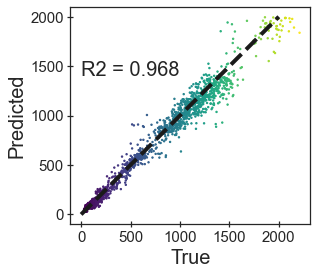

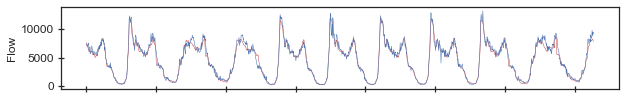

14037 WB P0
process ann data
process ann data
MAE 77.656395
MRE 0.13187328
RMSE 120.07945367677395


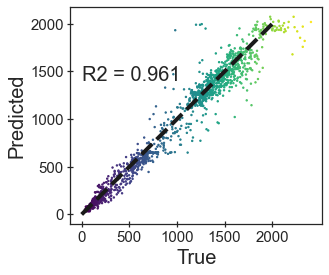

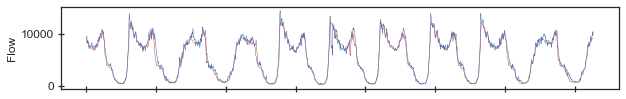

14025 WB P0
process ann data
process ann data
MAE 68.86173
MRE 0.14788724
RMSE 100.99045630961868


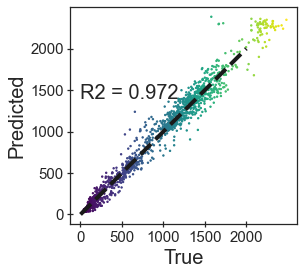

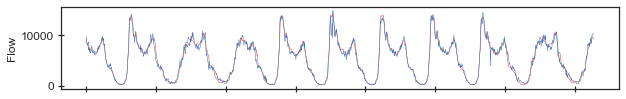

14049 WB P0
process ann data
process ann data
MAE 43.79174
MRE 0.12868316
RMSE 64.94693221320196


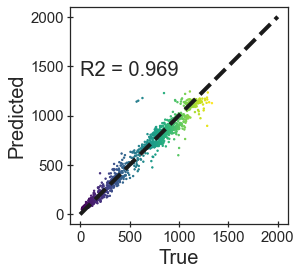

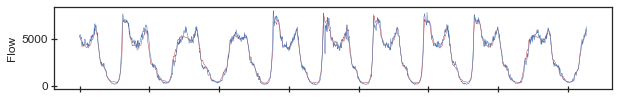

14063 WB P0
process ann data
process ann data
MAE 24.734627
MRE 0.14700691
RMSE 41.0208716882333


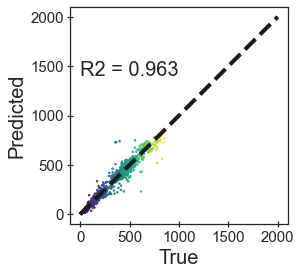

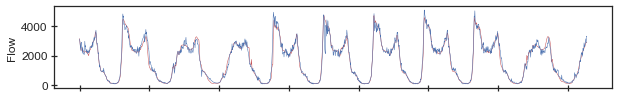

14005 WB P0
process ann data
process ann data
MAE 46.597713
MRE 0.22560889
RMSE 64.84238703386852


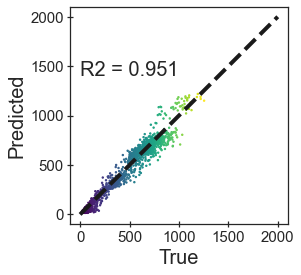

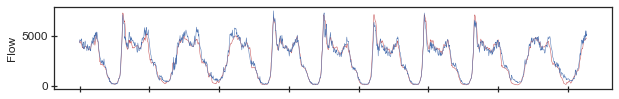

14055 WB P0
process ann data
process ann data
MAE 83.19726
MRE 0.12603652
RMSE 130.85734420065998


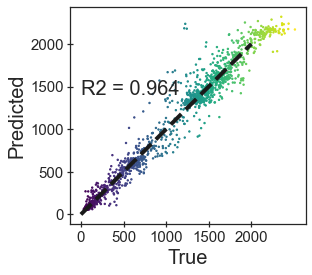

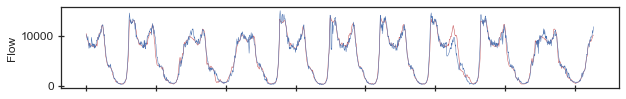

sums of MAE test /counter 58.27578462873186


In [18]:
final = pd.DataFrame()
MAE_LSTM, MRE_LSTM, RMSE_LSTM = {},{},{}

for siteId in sites:
    print(siteId)
    tmp = data[data['site']==siteId]
    tmp = tmp.reset_index()
    if len(tmp) == 0:
        print('error',siteId)
        continue
    tmp = tmp.dropna()

    index = len(tmp) * 0.80
    train = tmp.loc[:index]
    test = tmp.loc[index-1:]
    len(train)/len(tmp) * 100 

    # ################
    # Section 1 : Data
    # ################
    index = len(tmp) * 0.80
    train = tmp.loc[:index]
    test = tmp.loc[index-1:]
    len(train)/len(tmp) * 100 

    ### Normalise all data (simulated and real accidents dataset) and create lags.
    train_norm, _ = normalise(features+['volume0'],train)
    test_norm, _ = normalise(features+['volume0'],test)

    _, scaler_train = normalise(['volume0'],train)
    _, scaler_test = normalise(['volume0'],test)

    # here the train y is normalized, but test y is not
    y_train = train_norm['volume0']
    x_train = train_norm[columns]
    y_test = test['volume0'] #not normalised volume - why? - because in the final compare we need to convert it back to de-normalized value
    x_test = test_norm[columns]

    # please read the detail in time_series_window_generator function to see how baseline is defined
    train_x, train_x_aux, train_y, y_base_train  = prepare_nn_data(x_train,y_train,lag,window,features_name)
    test_x, test_x_aux, test_y, y_base_test = prepare_nn_data(x_test,y_test,lag,window,features_name)

    # get baseline ready
    y_base_train = np.asarray(x_train[:-lag]).astype(np.float32)
    y_base_test = np.asarray(test[features_name][:-lag]).astype(np.float32)    # need original x_feature value from test set

    # ################
    # Section 2 : model
    # ################
    main_input = Input(shape = (1,window), dtype = 'float32', name = 'main_input')
    lstm_out = LSTM(64,return_sequences=True, activation = 'relu',
                    kernel_regularizer=regularizers.l2(0.0001)) (main_input)

    aux_input = Input(shape=(train_x_aux.shape[1],train_x_aux.shape[2]), name = 'aux_input')
    x = concatenate([lstm_out, aux_input]) #concatenate auxiliary features with lstm output     

    #feed concatenated result into dense layers
    x = Dense(32, activation = 'relu') (x)
    x = Dense(16, activation = 'relu') (x)
    main_output = Dense(1, activation = 'linear', name = 'main_output') (x)

    model = Model(inputs = [main_input, aux_input], outputs = [main_output])    

    model.compile(loss='mean_absolute_error',  optimizer=Adam(learning_rate=0.001))    
    # model.summary()    

    history = model.fit({'main_input': train_x, 'aux_input': train_x_aux}, 
                        {'main_output': train_y}, epochs=400, batch_size=32, shuffle = False, verbose=0)

    filename = os.getcwd() + "\\Models\\LSTM\\LSTM_model_lag_" + str(lag) + "_" + str(siteId) + ".h5"
    model.save(filename)
    
#     filename = os.getcwd() + "\\Models\\LSTM\\LSTM_model_lag_" + str(lag) + "_" + str(siteId) + ".h5"
#     model = keras.models.load_model(filename)

    # ################
    # Section 3 : evaluation
    # ################
    ### visualise the loss over epochs 
#     plt.plot(history.history["loss"][0:500], linewidth = 2.5) # plot first 100 validation losses 
#     plt.xlabel("Epoch")
#     plt.ylabel("Loss")

    # before de-normalized
    y_pred_train_origin = model.predict({'main_input': train_x, 'aux_input': train_x_aux})
    y_pred_test_origin = model.predict({'main_input': test_x, 'aux_input': test_x_aux})

    ### Unnormalise the predictions to original scale. 
    y_pred_train = denormalise(y_pred_train_origin, scaler_train).flatten()
    y_pred_test = denormalise(y_pred_test_origin, scaler_test).flatten()

    # for evaluate the model we need all values in a de-normalise value
    # y_pred_train, y_pred_test are de-normalised
    # test_y, y_base_test are de-normalised
    train_y = np.asarray(train['volume0'][:-lag]).astype(np.float32)  # get y from vol-0
    train_y = np.reshape(train_y, (train_y.shape[0], 1))
    y_base_train = np.asarray(train[features_name][:-lag]).astype(np.float32) # get base from vol-1

    res = evaluate_model_ann(y_pred_train, y_pred_test, train_y, test_y, y_base_train, y_base_test)

    MAE_LSTM[siteId] = res['test mae']
    MRE_LSTM[siteId] = res['test mre']
    RMSE_LSTM[siteId] = res['test rmse']
    
    print('MAE', res['test mae'])
    print('MRE', res['test mre'])
    print('RMSE', res['test rmse'])

    show_time_scatter_plot(test_y.flatten(), y_pred_test,title = "LSTM\\")

    x_test_time = test[['dateTime','speed0','density0','state0','volume0']][:-lag]
    x_test_time = x_test_time.reset_index(drop=True)
    y_pred_test = pd.Series(y_pred_test)
    y_pred_test = y_pred_test.reset_index(drop=True)
    tmp1 = pd.concat([x_test_time,y_pred_test], axis=1)
    tmp1.columns = ['dateTime','speed0','density0','state0','volume0','pvolume']
    tmp1['site'] = siteId
    final = final.append(tmp1)

final.to_csv('C:\\Data\\predicted_lstm.csv',index=False)

sums, counter = 0, 0
for key in MAE_LSTM:
    sums += MAE_LSTM[key]
    counter+= 1

print('sums of MAE test /counter', sums/counter)



# GRU

14011 WB P0
process ann data
process ann data
MAE 67.89302
MRE 0.12336268
RMSE 96.72457070530217


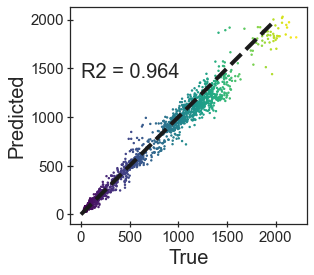

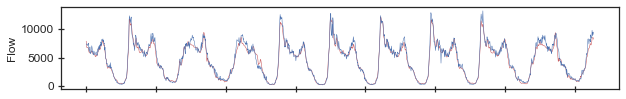

14037 WB P0
process ann data
process ann data
MAE 76.04585
MRE 0.16943976
RMSE 111.6642436965052


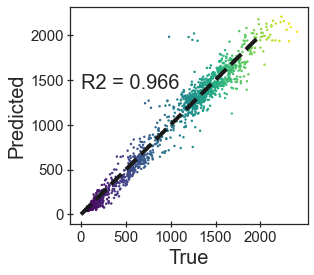

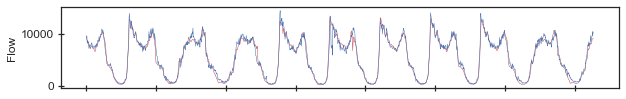

14025 WB P0
process ann data
process ann data
MAE 72.248726
MRE 0.1247801
RMSE 106.90825506012153


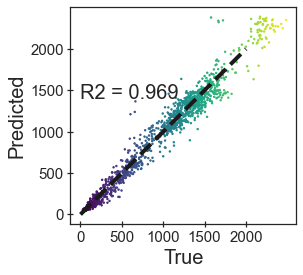

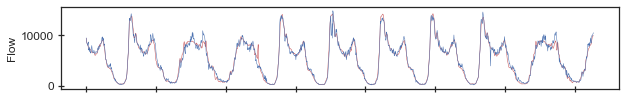

14049 WB P0
process ann data
process ann data
MAE 45.91796
MRE 0.14315511
RMSE 67.1970160412183


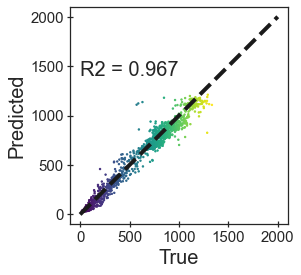

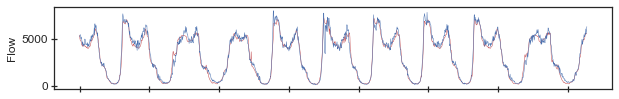

14063 WB P0
process ann data
process ann data
MAE 24.411139
MRE 0.18635833
RMSE 39.064549946210825


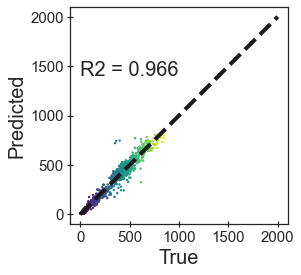

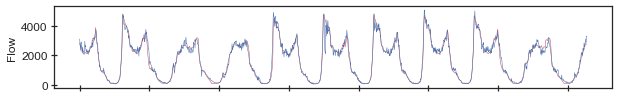

14005 WB P0
process ann data
process ann data
MAE 50.05788
MRE 0.20750171
RMSE 69.5288798753349


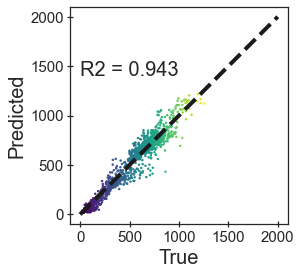

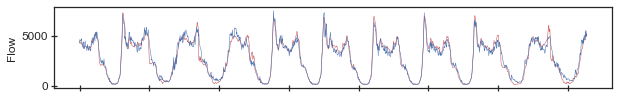

14055 WB P0
process ann data
process ann data
MAE 83.60719
MRE 0.12935548
RMSE 127.96001954345935


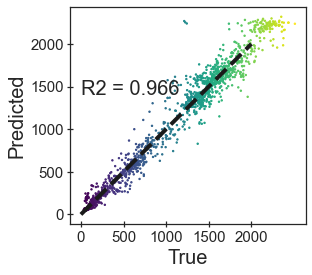

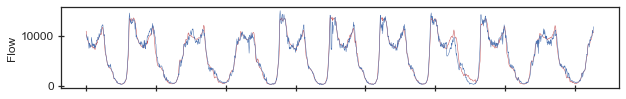

sums of MAE test /counter 60.02596746172224


In [19]:
final = pd.DataFrame()
MAE_GRU, MRE_GRU, RMSE_GRU = {},{},{}


for siteId in sites:
    print(siteId)
    tmp = data[data['site']==siteId]
    tmp = tmp.reset_index()
    if len(tmp) == 0:
        print('error',siteId)
        continue
    tmp = tmp.dropna()

    index = len(tmp) * 0.80
    train = tmp.loc[:index]
    test = tmp.loc[index-1:]
    len(train)/len(tmp) * 100 

    # ################
    # Section 1 : Data
    # ################
    index = len(tmp) * 0.80
    train = tmp.loc[:index]
    test = tmp.loc[index-1:]
    len(train)/len(tmp) * 100 

    ### Normalise all data (simulated and real accidents dataset) and create lags.
    train_norm, _ = normalise(features+['volume0'],train)
    test_norm, _ = normalise(features+['volume0'],test)

    _, scaler_train = normalise(['volume0'],train)
    _, scaler_test = normalise(['volume0'],test)

    # here the train y is normalized, but test y is not
    y_train = train_norm['volume0']
    x_train = train_norm[columns]
    y_test = test['volume0'] #not normalised volume - why? - because in the final compare we need to convert it back to de-normalized value
    x_test = test_norm[columns]

    # please read the detail in time_series_window_generator function to see how baseline is defined
    train_x, train_x_aux, train_y, y_base_train  = prepare_nn_data(x_train,y_train,lag,window,features_name)
    test_x, test_x_aux, test_y, y_base_test = prepare_nn_data(x_test,y_test,lag,window,features_name)

    # get baseline ready
    y_base_train = np.asarray(x_train[:-lag]).astype(np.float32)
    y_base_test = np.asarray(test[features_name][:-lag]).astype(np.float32)    # need original x_feature value from test set

    # ################
    # Section 2 : model
    # ################
    main_input = Input(shape = (1,window), dtype = 'float32', name = 'main_input')
    gru_out = GRU(64,return_sequences=True, activation = 'relu',
                    kernel_regularizer=regularizers.l2(0.0001)) (main_input)

    aux_input = Input(shape=(train_x_aux.shape[1],train_x_aux.shape[2]), name = 'aux_input')
    x = concatenate([gru_out, aux_input]) #concatenate auxiliary features with gru output     

    #feed concatenated result into dense layers
    x = Dense(32, activation = 'relu') (x)
    x = Dense(16, activation = 'relu') (x)
    main_output = Dense(1, activation = 'linear', name = 'main_output') (x)

    model = Model(inputs = [main_input, aux_input], outputs = [main_output])    

    model.compile(loss='mean_absolute_error',  optimizer=Adam(learning_rate=0.001))    
    # model.summary()    

    history = model.fit({'main_input': train_x, 'aux_input': train_x_aux}, 
                        {'main_output': train_y}, epochs=400, batch_size=32, shuffle = False, verbose=0)

    filename = os.getcwd() + "\\Models\\GRU\\GRU_model_lag_" + str(lag) + "_" + str(siteId) + ".h5"
    model.save(filename)
    
#     filename = os.getcwd() + "\\Models\\GRU\\GRU_model_lag_" + str(lag) + "_" + str(siteId) + ".h5"
#     model = keras.models.load_model(filename)

    # ################
    # Section 3 : evaluation
    # ################
    ### visualise the loss over epochs 
#     plt.plot(history.history["loss"][0:500], linewidth = 2.5) # plot first 100 validation losses 
#     plt.xlabel("Epoch")
#     plt.ylabel("Loss")

    # before de-normalized
    y_pred_train_origin = model.predict({'main_input': train_x, 'aux_input': train_x_aux})
    y_pred_test_origin = model.predict({'main_input': test_x, 'aux_input': test_x_aux})

    ### Unnormalise the predictions to original scale. 
    y_pred_train = denormalise(y_pred_train_origin, scaler_train).flatten()
    y_pred_test = denormalise(y_pred_test_origin, scaler_test).flatten()

    # for evaluate the model we need all values in a de-normalise value
    # y_pred_train, y_pred_test are de-normalised
    # test_y, y_base_test are de-normalised
    train_y = np.asarray(train['volume0'][:-lag]).astype(np.float32)  # get y from vol-0
    train_y = np.reshape(train_y, (train_y.shape[0], 1))
    y_base_train = np.asarray(train[features_name][:-lag]).astype(np.float32) # get base from vol-1

    res = evaluate_model_ann(y_pred_train, y_pred_test, train_y, test_y, y_base_train, y_base_test)

    MAE_GRU[siteId] = res['test mae']
    MRE_GRU[siteId] = res['test mre']
    RMSE_GRU[siteId] = res['test rmse']
    
    print('MAE', res['test mae'])
    print('MRE', res['test mre'])
    print('RMSE', res['test rmse'])

    show_time_scatter_plot(test_y.flatten(), y_pred_test,title = "GRU\\")

    x_test_time = test[['dateTime','speed0','density0','state0','volume0']][:-lag]
    x_test_time = x_test_time.reset_index(drop=True)
    y_pred_test = pd.Series(y_pred_test)
    y_pred_test = y_pred_test.reset_index(drop=True)
    tmp1 = pd.concat([x_test_time,y_pred_test], axis=1)
    tmp1.columns = ['dateTime','speed0','density0','state0','volume0','pvolume']
    tmp1['site'] = siteId
    final = final.append(tmp1)

final.to_csv('C:\\Data\\predicted_gru.csv',index=False)

sums, counter = 0, 0
for key in MAE_GRU:
    sums += MAE_GRU[key]
    counter+= 1

print('sums of MAE test /counter', sums/counter)



# Bidirectional LSTM

14011 WB P0
process ann data
process ann data
train mae 63.83898
test mae 66.578804
base train mae 842.9468
base test mae 848.27545
test mre 0.19106802
test rmse 95.07437980503738
base model train error [4785409.]
base model test error [1234240.8]
our model train error [362415.]
our model test error [96872.266]
Model R square (train):  0.9682097437480381
Model R square (test):  0.9654900390732254
Base R square (train):  -1.9216588992524675
Base R square (test):  -1.9863643404381723


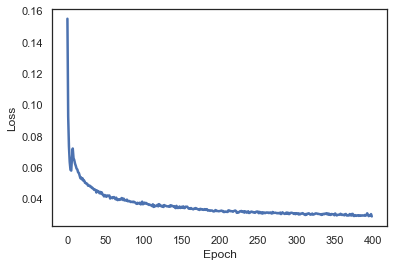

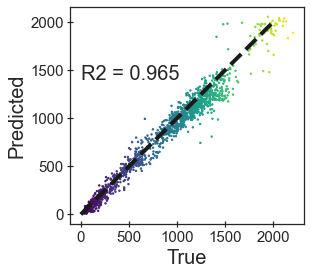

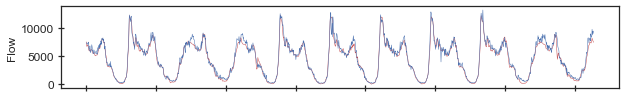

14037 WB P0
process ann data
process ann data
train mae 72.38392
test mae 73.03291
base train mae 1042.2783
base test mae 1041.118
test mre 0.12150528
test rmse 113.66565382460526
base model train error [5917014.5]
base model test error [1514827.4]
our model train error [410923.66]
our model test error [106262.86]
Model R square (train):  0.9693161186564404
Model R square (test):  0.9651198218856921
Base R square (train):  -2.1450963329377184
Base R square (test):  -2.1993793631833833


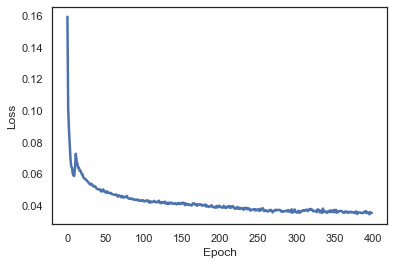

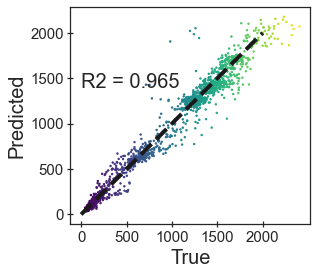

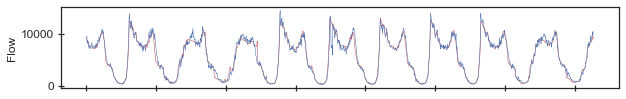

14025 WB P0
process ann data
process ann data
train mae 64.472435
test mae 65.09087
base train mae 1015.20233
base test mae 1019.23193
test mre 0.1340687
test rmse 96.55869733612815
base model train error [5763301.]
base model test error [1482982.5]
our model train error [366009.97]
our model test error [94707.18]
Model R square (train):  0.9759949412292139
Model R square (test):  0.9745656272658162
Base R square (train):  -2.008638020588473
Base R square (test):  -2.0811300704187845


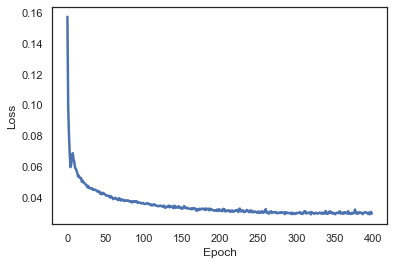

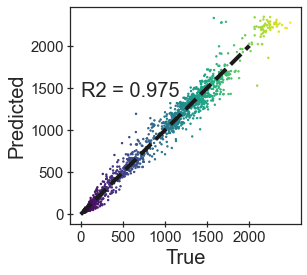

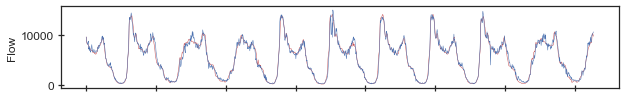

14049 WB P0
process ann data
process ann data
train mae 41.716995
test mae 42.535553
base train mae 632.0373
base test mae 640.5112
test mre 0.11474597
test rmse 70.84176496998434
base model train error [3588077.2]
base model test error [931944.]
our model train error [236827.4]
our model test error [61889.242]
Model R square (train):  0.9705880737569295
Model R square (test):  0.9633982931272711
Base R square (train):  -2.186522337882114
Base R square (test):  -2.2615910518109774


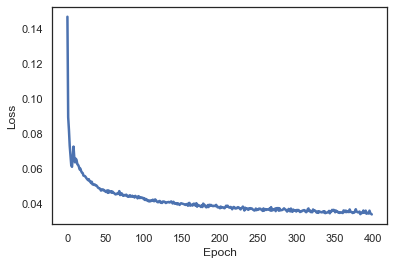

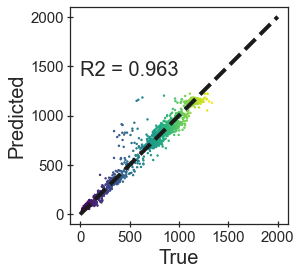

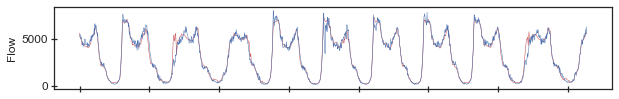

14063 WB P0
process ann data
process ann data
train mae 24.101673
test mae 24.59494
base train mae 365.34653
base test mae 361.66077
test mre 0.16162764
test rmse 39.67816234886405
base model train error [2074073.9]
base model test error [526216.5]
our model train error [136825.16]
our model test error [35785.625]
Model R square (train):  0.9720031990564753
Model R square (test):  0.9649232416231287
Base R square (train):  -2.083166435519254
Base R square (test):  -2.171444004025782


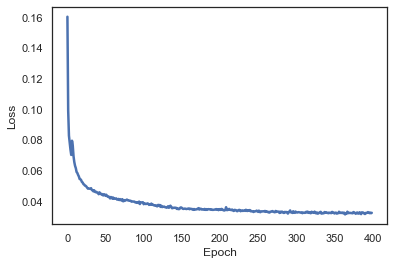

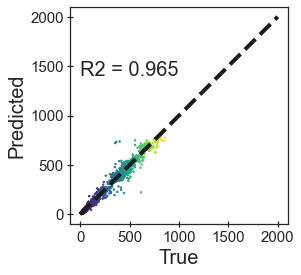

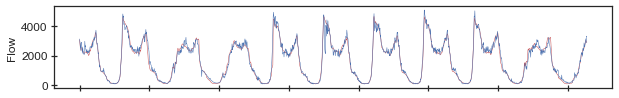

14005 WB P0
process ann data
process ann data
train mae 47.35591
test mae 48.207485
base train mae 463.4476
base test mae 487.46176
test mre 0.27855077
test rmse 66.27847265515403
base model train error [2630990.8]
base model test error [709256.7]
our model train error [268839.94]
our model test error [70141.83]
Model R square (train):  0.9471270283976462
Model R square (test):  0.9484231968271312
Base R square (train):  -1.9835709413165334
Base R square (test):  -2.0947650402226916


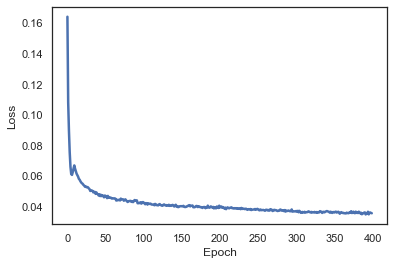

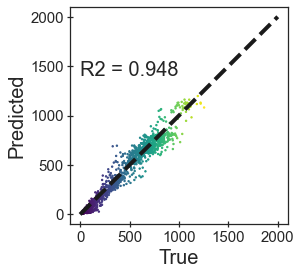

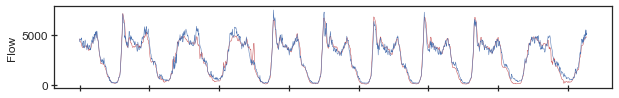

14055 WB P0
process ann data
process ann data
train mae 75.2075
test mae 88.70565
base train mae 1197.4545
base test mae 1191.282
test mre 0.17212665
test rmse 135.50881400069517
base model train error [6797950.]
base model test error [1733315.1]
our model train error [426953.47]
our model test error [129066.734]
Model R square (train):  0.975302021153062
Model R square (test):  0.9615667538594954
Base R square (train):  -2.169543973675732
Base R square (test):  -2.2409352691819606


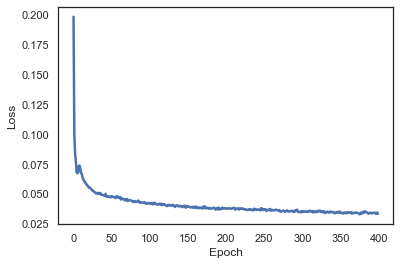

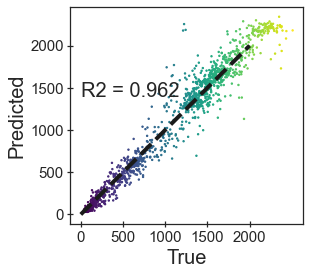

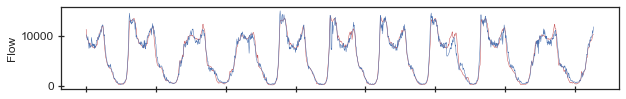

sums of MAE test /counter 58.39231709071568


In [20]:
final = pd.DataFrame()
MAE_BiLSTM, MRE_BiLSTM, RMSE_BiLSTM = {},{},{}

for siteId in sites:
    print(siteId)
    tmp = data[data['site']==siteId]
    tmp = tmp.reset_index()
    if len(tmp) == 0:
        print('error',siteId)
        continue
    tmp = tmp.dropna()

    index = len(tmp) * 0.80
    train = tmp.loc[:index]
    test = tmp.loc[index-1:]
    len(train)/len(tmp) * 100 

    # ################
    # Section 1 : Data
    # ################
    index = len(tmp) * 0.80
    train = tmp.loc[:index]
    test = tmp.loc[index-1:]
    len(train)/len(tmp) * 100 

    ### Normalise all data (simulated and real accidents dataset) and create lags.
    train_norm, _ = normalise(features+['volume0'],train)
    test_norm, _ = normalise(features+['volume0'],test)

    _, scaler_train = normalise(['volume0'],train)
    _, scaler_test = normalise(['volume0'],test)

    # here the train y is normalized, but test y is not
    y_train = train_norm['volume0']
    x_train = train_norm[columns]
    y_test = test['volume0'] #not normalised volume - why? - because in the final compare we need to convert it back to de-normalized value
    x_test = test_norm[columns]

    # please read the detail in time_series_window_generator function to see how baseline is defined
    train_x, train_x_aux, train_y, y_base_train  = prepare_nn_data(x_train,y_train,lag,window,features_name)
    test_x, test_x_aux, test_y, y_base_test = prepare_nn_data(x_test,y_test,lag,window,features_name)

    # get baseline ready
    y_base_train = np.asarray(x_train[:-lag]).astype(np.float32)
    y_base_test = np.asarray(test[features_name][:-lag]).astype(np.float32)    # need original x_feature value from test set

    # ################
    # Section 2 : model
    # ################
    main_input = Input(shape = (1,window), dtype = 'float32', name = 'main_input')
    lstm_out = Bidirectional(LSTM(64,return_sequences=True, activation = 'relu',
                    kernel_regularizer=regularizers.l2(0.0001))) (main_input)

    aux_input = Input(shape=(train_x_aux.shape[1],train_x_aux.shape[2]), name = 'aux_input')
    x = concatenate([lstm_out, aux_input]) #concatenate auxiliary features with lstm output     

    #feed concatenated result into dense layers
    x = Dense(32, activation = 'relu') (x)
    x = Dense(16, activation = 'relu') (x)
    main_output = Dense(1, activation = 'linear', name = 'main_output') (x)

    model = Model(inputs = [main_input, aux_input], outputs = [main_output])      


    model.compile(loss='mean_absolute_error',  optimizer=Adam(learning_rate=0.001))    
    # model.summary()    

    history = model.fit({'main_input': train_x, 'aux_input': train_x_aux}, 
                   {'main_output': train_y}, epochs=400, batch_size=32, shuffle = False, verbose=0)

    filename = os.getcwd() + "\\Models\\BiLSTM\\LSTM_model_lag_" + str(lag) + "_" + str(siteId) + ".h5"
    model.save(filename)
    
#     filename = os.getcwd() + "\\Models\\BiLSTM\\LSTM_model_lag_" + str(lag) + "_" + str(siteId) + ".h5"
#     model = keras.models.load_model(filename)


    # ################
    # Section 3 : evaluation
    # ################
    ### visualise the loss over epochs 
    plt.plot(history.history["loss"][0:500], linewidth = 2.5) # plot first 100 validation losses 
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    # before de-normalized
    y_pred_train_origin = model.predict({'main_input': train_x, 'aux_input': train_x_aux})
    y_pred_test_origin = model.predict({'main_input': test_x, 'aux_input': test_x_aux})

    ### Unnormalise the predictions to original scale. 
    y_pred_train = denormalise(y_pred_train_origin, scaler_train).flatten()
    y_pred_test = denormalise(y_pred_test_origin, scaler_test).flatten()

    # for evaluate the model we need all values in a de-normalise value
    # y_pred_train, y_pred_test are de-normalised
    # test_y, y_base_test are de-normalised
    train_y = np.asarray(train['volume0'][:-lag]).astype(np.float32)  # get y from vol-0
    train_y = np.reshape(train_y, (train_y.shape[0], 1))
    y_base_train = np.asarray(train[features_name][:-lag]).astype(np.float32) # get base from vol-1

    res = evaluate_model_ann(y_pred_train, y_pred_test, train_y, test_y, y_base_train, y_base_test)
    for key in res:
        print(key, res[key])
    print('Model R square (train): ', r2_score(train_y.flatten(), y_pred_train))  
    print('Model R square (test): ', r2_score(test_y.flatten(), y_pred_test))     # both are after norm
    print('Base R square (train): ', r2_score(train_y.flatten(), y_base_train))   # both are after norm
    print('Base R square (test): ', r2_score(test_y.flatten(), y_base_test))

    MAE_BiLSTM[siteId] = res['test mae']
    MRE_BiLSTM[siteId] = res['test mre']
    RMSE_BiLSTM[siteId] = res['test rmse']
    
    show_time_scatter_plot(test_y.flatten(), y_pred_test,title = "BiLSTM\\")

    x_test_time = test[['dateTime','speed0','density0','state0']][:-lag]
    x_test_time = x_test_time.reset_index()
    y_test = pd.Series(y_test)
    y_pred_test = pd.Series(y_pred_test)
    tmp1 = pd.concat([x_test_time,y_test,y_pred_test], axis=1)
    tmp1.columns = ['index','dateTime','speed0','density0','state0','volume0','pvolume']
    tmp1['site'] = siteId
    final = final.append(tmp1)

final.to_csv('C:\\Data\\predicted_bilstm.csv',index=False)

sums, counter = 0, 0
for key in MAE_BiLSTM:
    sums += MAE_BiLSTM[key]
    counter+= 1

print('sums of MAE test /counter', sums/counter)


## Final statistics

In [21]:
sums, counter = 0, 0
for site in sites:
    sums += MAE_RNN[site]
    counter+= 1
print('sums of MAE test /counter', sums/counter)
sums, counter = 0, 0
for site in sites:
    sums += MRE_RNN[site]
    counter+= 1
print('sums of MRE test /counter', sums/counter)
sums, counter = 0, 0
for site in sites:
    sums += RMSE_RNN[site]
    counter+= 1
print('sums of RMSE test /counter', sums/counter)

sums of MAE test /counter 61.582184110369
sums of MRE test /counter 0.4615123165505273
sums of RMSE test /counter 90.47235036547174


In [22]:
sums, counter = 0, 0
for site in sites:
    sums += MAE_LSTM[site]
    counter+= 1
print('sums of MAE test /counter', sums/counter)
sums, counter = 0, 0
for site in sites:
    sums += MRE_LSTM[site]
    counter+= 1
print('sums of MRE test /counter', sums/counter)
sums, counter = 0, 0
for site in sites:
    sums += RMSE_LSTM[site]
    counter+= 1
print('sums of RMSE test /counter', sums/counter)

sums of MAE test /counter 58.27578462873186
sums of MRE test /counter 0.14658722920077188
sums of RMSE test /counter 87.84853617929582


In [23]:
sums, counter = 0, 0
for site in sites:
    sums += MAE_GRU[site]
    counter+= 1
print('sums of MAE test /counter', sums/counter)
sums, counter = 0, 0
for site in sites:
    sums += MRE_GRU[site]
    counter+= 1
print('sums of MRE test /counter', sums/counter)
sums, counter = 0, 0
for site in sites:
    sums += RMSE_GRU[site]
    counter+= 1
print('sums of RMSE test /counter', sums/counter)

sums of MAE test /counter 60.02596746172224
sums of MRE test /counter 0.1548504542027201
sums of RMSE test /counter 88.43536212402175


In [24]:
sums, counter = 0, 0
for site in sites:
    sums += MAE_BiLSTM[site]
    counter+= 1
print('sums of MAE test /counter', sums/counter)
sums, counter = 0, 0
for site in sites:
    sums += MRE_BiLSTM[site]
    counter+= 1
print('sums of MRE test /counter', sums/counter)
sums, counter = 0, 0
for site in sites:
    sums += RMSE_BiLSTM[site]
    counter+= 1
print('sums of RMSE test /counter', sums/counter)

sums of MAE test /counter 58.39231709071568
sums of MRE test /counter 0.1676704330103738
sums of RMSE test /counter 88.2294207057812


## No Model

In [28]:
final = pd.DataFrame()
MAE_NM, MRE_NM, RMSE_NM = {},{},{}

for siteId in sites:
    print(siteId)
    tmp = data[data['site']==siteId]
    tmp = tmp.reset_index()
    tmp = tmp.dropna()
    
    if len(tmp) == 0:
        print('error',siteId)
        continue

    index = len(tmp) * 0.80
    train = tmp.loc[:index]
    test = tmp.loc[index-1:]
    len(train)/len(tmp) * 100 
    
    # we use 'vol - 0' as the prediction target
    # vol-x means how much hour before vol-0
    y_train = train['volume0'] #not normalised travel times 
    x_train = train[columns]
    y_test = test['volume0'] #not normalised travel times 
    x_test = test[columns]

    
    # please read the detail in time_series_window_generator function to see how baseline is defined
    x_train_win, y_train_win, y_train_win_base  = time_series_window_generator(x_train,y_train,lag,window,features_name)
    x_test_win, y_test_win, y_test_win_base = time_series_window_generator(x_test,y_test,lag,window,features_name)

    
    # forecasting results
    y_pred_train = x_train[columns[0]].values.tolist()[:-lag]
    y_pred_test = x_test[columns[0]].values.tolist()[:-lag]
    #print(y_pred_train)

    res = evaluate_model(y_pred_train, y_pred_test, y_train_win, y_test_win, y_train_win_base, y_test_win_base)

    MAE_NM[siteId] = res['MAE test']
    MRE_NM[siteId] = res['MRE test']
    RMSE_NM[siteId] = res['RMSE test']
    
    print('MAE', res['MAE test'])
    print('MRE', res['MRE test'])
    print('RMSE', res['RMSE test'])
    
    #show_time_scatter_plot(y_test_win,y_pred_test, title = "NM\\")
    
    x_test_time = test[['dateTime','speed0','density0','state0']][:-lag]
    x_test_time = x_test_time.reset_index()
    y_test_win = pd.Series(y_test_win)
    y_pred_test = pd.Series(y_pred_test)
    tmp1 = pd.concat([x_test_time,y_test_win,y_pred_test], axis=1)
    tmp1.columns = ['index','dateTime','speed0','density0','state0','volume0','pvolume']
    tmp1['site'] = siteId
    final = final.append(tmp1)
    
final.to_csv('C:\\Data\\predicted_nm.csv',index=False)

sums, counter = 0, 0
for key in MAE_NM:
    sums += MAE_NM[key]
    counter+= 1

print('sums of MAE test /counter', sums/counter)

14063 WB P0
MAE 227.5577698087432
MRE 5.441103122006991
RMSE 290.7717879818467
14005 WB P0
MAE 316.2717713212334
MRE 3.1029241847115343
RMSE 394.6874040812967
14049 WB P0
MAE 405.478981264637
MRE 3.727515603534091
RMSE 504.3097985184252
14055 WB P0
MAE 753.6767710772834
MRE 3.91717834889051
RMSE 943.0534783535269
14037 WB P0
MAE 668.1787431693989
MRE 3.1513536920474694
RMSE 828.6401734181379
14011 WB P0
MAE 569.0439890710381
MRE 3.6562906865644553
RMSE 714.504344674919
14025 WB P0
MAE 669.9843091334894
MRE 4.175345570672802
RMSE 845.4395312324768
sums of MAE test /counter 515.7417621208318


In [29]:
sums, counter = 0, 0
for site in sites:
    sums += MAE_NM[site]
    counter+= 1
print('sums of MAE test /counter', sums/counter)
sums, counter = 0, 0
for site in sites:
    sums += MRE_NM[site]
    counter+= 1
print('sums of MRE test /counter', sums/counter)
sums, counter = 0, 0
for site in sites:
    sums += RMSE_NM[site]
    counter+= 1
print('sums of RMSE test /counter', sums/counter)

sums of MAE test /counter 515.7417621208318
sums of MRE test /counter 3.881673029775407
sums of RMSE test /counter 645.9152168943757


# MLP

In [55]:
final = pd.DataFrame()
MAE_MLP, MRE_MLP, RMSE_MLP = {},{},{}

for siteId in sites:
    print(siteId)
    tmp = data[data['site']==siteId]
    tmp = tmp.reset_index()
    if len(tmp) == 0:
        print('error',siteId)
        continue
    tmp = tmp.dropna()

    index = len(tmp) * 0.80
    train = tmp.loc[:index]
    test = tmp.loc[index-1:]
    len(train)/len(tmp) * 100 

    # ################
    # Section 1 : Data
    # ################
    index = len(tmp) * 0.80
    train = tmp.loc[:index]
    test = tmp.loc[index-1:]
    len(train)/len(tmp) * 100 

    ### Normalise all data (simulated and real accidents dataset) and create lags.
    train_norm, _ = normalise(features+['volume0'],train)
    test_norm, _ = normalise(features+['volume0'],test)

    _, scaler_train = normalise(['volume0'],train)
    _, scaler_test = normalise(['volume0'],test)

    # here the train y is normalized, but test y is not
    y_train = train_norm['volume0']
    x_train = train_norm[columns]
    y_test = test['volume0'] #not normalised volume - why? - because in the final compare we need to convert it back to de-normalized value
    x_test = test_norm[columns]

    # please read the detail in time_series_window_generator function to see how baseline is defined
    train_x, train_x_aux, train_y, y_base_train  = prepare_nn_data(x_train,y_train,lag,window,features_name)
    test_x, test_x_aux, test_y, y_base_test = prepare_nn_data(x_test,y_test,lag,window,features_name)

    # get baseline ready
    y_base_train = np.asarray(x_train[:-lag]).astype(np.float32)
    y_base_test = np.asarray(test[features_name][:-lag]).astype(np.float32)    # need original x_feature value from test set

    ################
    # Section 2 : model
    ################

    model = Sequential()
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=0.001))
    history = model.fit(train_x, train_y, epochs=400, batch_size=32, shuffle = False, verbose=0)
    
    
    filename = os.getcwd() + "\\Models\\MLP\\MLP_model_lag_" + str(lag) + "_" + str(siteId) + ".h5"
    model.save(filename)
    
#     filename = os.getcwd() + "\\Models\\MLP\\MLP_model_lag_" + str(lag) + "_" + str(siteId) + ".h5"
#     model = keras.models.load_model(filename)

    ################
    # Section 3 : evaluation
    ################
    ## visualise the loss over epochs 
    plt.plot(history.history["loss"][0:500], linewidth = 2.5) # plot first 100 validation losses 
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    # before de-normalized
    y_pred_train_origin = model.predict(train_x)
    y_pred_test_origin = model.predict( test_x)

    ### Unnormalise the predictions to original scale. 
    y_pred_train = denormalise(y_pred_train_origin, scaler_train).flatten()
    y_pred_test = denormalise(y_pred_test_origin, scaler_test).flatten()

    # for evaluate the model we need all values in a de-normalise value
    # y_pred_train, y_pred_test are de-normalised
    # test_y, y_base_test are de-normalised
    train_y = np.asarray(train['volume0'][:-lag]).astype(np.float32)  # get y from vol-0
    train_y = np.reshape(train_y, (train_y.shape[0], 1))
    y_base_train = np.asarray(train[features_name][:-lag]).astype(np.float32) # get base from vol-1

    res = evaluate_model_ann(y_pred_train, y_pred_test, train_y, test_y, y_base_train, y_base_test)
    for key in res:
        print(key, res[key])

    MAE_MLP[siteId] = res['test mae']
    MRE_MLP[siteId] = res['test mre']
    RMSE_MLP[siteId] = res['test rmse']
    
    show_time_scatter_plot(test_y.flatten(), y_pred_test,title = "MLP\\")

    x_test_time = test[['dateTime','speed0','density0','state0','volume0']][:-lag]
    x_test_time = x_test_time.reset_index(drop=True)
    y_pred_test = pd.Series(y_pred_test)
    y_pred_test = y_pred_test.reset_index(drop=True)
    tmp1 = pd.concat([x_test_time,y_pred_test], axis=1)
    tmp1.columns = ['dateTime','speed0','density0','state0','volume0','pvolume']
    tmp1['site'] = siteId
    final = final.append(tmp1)

final.to_csv('C:\\Data\\predicted_mlp.csv',index=False)

sums, counter = 0, 0
for key in MAE_MLP:
    sums += MAE_MLP[key]
    counter+= 1

print('sums of MAE test /counter', sums/counter)

